In [2]:
cd dockerdata/PySR/

/dockerdata/PySR


/env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [1]:
#pinn
import torch
import torch.nn as nn
from collections import OrderedDict

# 定义神经网络的架构
class Network(nn.Module):
    # 构造函数
    def __init__(
        self,
        input_size, # 输入层神经元数
        hidden_size, # 隐藏层神经元数
        output_size, # 输出层神经元数
        depth, # 隐藏层数
        act=torch.nn.Tanh, # 输入层和隐藏层的激活函数
    ):
        super(Network, self).__init__()#调用父类的构造函数

        # 输入层
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))

        # 隐藏层
        for i in range(depth):
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, act()))

        # 输出层
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        #将这些层组装为神经网络
        self.layers = torch.nn.Sequential(OrderedDict(layers))

    # 前向计算方法
    def forward(self, x):
        return self.layers(x)



In [4]:
import math
import torch
import numpy as np

# 定义一个类，用于实现PINN(Physics-informed Neural Networks)
class PINN:
    # 构造函数
    def __init__(self):
        # 选择使用GPU还是CPU
        device = torch.device(
            "cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        # 定义神经网络
        self.model = Network(
            input_size=2,  # 输入层神经元数
            hidden_size=16,  # 隐藏层神经元数
            output_size=1,  # 输出层神经元数
            depth=8,  # 隐藏层数
            act=torch.nn.Tanh  # 输入层和隐藏层的激活函数
        ).to(device)  # 将这个神经网络存储在GPU上（若GPU可用）

        self.h = 0.1  # 设置空间步长
        self.k = 0.1  # 设置时间步长
        x = torch.arange(-1, 1 + self.h, self.h)  # 在[-1,1]区间上均匀取值，记为x
        t = torch.arange(0, 1 + self.k, self.k)  # 在[0,1]区间上均匀取值，记为t

        # 将x和t组合，形成时间空间网格，记录在张量X_inside中
        self.X_inside = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T

        # 边界处的时空坐标
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T  # x=-1边界
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T  # x=+1边界
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T  # t=0边界
        self.X_boundary = torch.cat([bc1, bc2, ic])  # 将所有边界处的时空坐标点整合为一个张量

        # 边界处的u值
        u_bc1 = torch.zeros(len(bc1))  # x=-1边界处采用第一类边界条件u=0
        u_bc2 = torch.zeros(len(bc2))  # x=+1边界处采用第一类边界条件u=0
        u_ic = -torch.sin(math.pi * ic[:, 0])  # t=0边界处采用第一类边界条件u=-sin(pi*x)
        self.U_boundary = torch.cat([u_bc1, u_bc2, u_ic])  # 将所有边界处的u值整合为一个张量
        self.U_boundary = self.U_boundary.unsqueeze(1)

        # 将数据拷贝到GPU
        self.X_inside = self.X_inside.to(device)
        self.X_boundary = self.X_boundary.to(device)
        self.U_boundary = self.U_boundary.to(device)
        self.X_inside.requires_grad = True  # 设置：需要计算对X的梯度

        # 设置准则函数为MSE，方便后续计算MSE
        self.criterion = torch.nn.MSELoss()

        # 定义迭代序号，记录调用了多少次loss
        self.iter = 1

        # 设置lbfgs优化器
        self.lbfgs = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )

        # 设置adam优化器
        self.adam = torch.optim.Adam(self.model.parameters())

    # 损失函数
    def loss_func(self):
        # 将导数清零
        self.adam.zero_grad()
        self.lbfgs.zero_grad()

        # 第一部分loss: 边界条件不吻合产生的loss
        U_pred_boundary = self.model(self.X_boundary)  # 使用当前模型计算u在边界处的预测值
        loss_boundary = self.criterion(
            U_pred_boundary, self.U_boundary)  # 计算边界处的MSE

        # 第二部分loss:内点非物理产生的loss
        U_inside = self.model(self.X_inside)  # 使用当前模型计算内点处的预测值

        # 使用自动求导方法得到U对X的导数
        du_dX = torch.autograd.grad(
            inputs=self.X_inside,
            outputs=U_inside,
            grad_outputs=torch.ones_like(U_inside),
            retain_graph=True,
            create_graph=True
        )[0]
        du_dx = du_dX[:, 0]  # 提取对第x的导数
        du_dt = du_dX[:, 1]  # 提取对第t的导数

        # 使用自动求导方法得到U对X的二阶导数
        du_dxx = torch.autograd.grad(
            inputs=self.X_inside,
            outputs=du_dX,
            grad_outputs=torch.ones_like(du_dX),
            retain_graph=True,
            create_graph=True
        )[0][:, 0]
        loss_equation = self.criterion(
            du_dt + U_inside.squeeze() * du_dx, 0.01 / math.pi * du_dxx)  # 计算物理方程的MSE

        # 最终的loss由两项组成
        loss = loss_equation + loss_boundary

        # loss反向传播，用于给优化器提供梯度信息
        loss.backward()

        # 每计算100次loss在控制台上输出消息
        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss

    # 训练
    def train(self):
        self.model.train()  # 设置模型为训练模式

        # 首先运行5000步Adam优化器
        print("采用Adam优化器")
        for i in range(5000):
            self.adam.step(self.loss_func)
        # 然后运行lbfgs优化器
        print("采用L-BFGS优化器")
        self.lbfgs.step(self.loss_func)

# 实例化PINN
pinn = PINN()

# 开始训练
pinn.train()

# 将模型保存到文件
torch.save(pinn.model, 'model.pth')


/env/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


采用Adam优化器
100 0.15176264941692352
200 0.12940706312656403
300 0.04832492023706436
400 0.04446249082684517
500 0.04301905632019043
600 0.042715657502412796
700 0.041849806904792786
800 0.043303921818733215
900 0.03945896774530411
1000 0.03829710930585861
1100 0.04042539745569229
1200 0.04560987651348114
1300 0.04139412194490433
1400 0.035322148352861404
1500 0.03671152889728546
1600 0.03595965355634689
1700 0.03405606001615524
1800 0.03303823992609978
1900 0.03296424448490143
2000 0.03259396553039551
2100 0.03209507465362549
2200 0.03274281322956085
2300 0.030267242342233658
2400 0.0288477074354887
2500 0.028424222022294998
2600 0.027553943917155266
2700 0.027784351259469986
2800 0.02809596061706543
2900 0.028401952236890793
3000 0.028255688026547432
3100 0.026110129430890083
3200 0.028632905334234238
3300 0.02471613511443138
3400 0.030824363231658936
3500 0.030272014439105988
3600 0.023461688309907913
3700 0.02348317764699459
3800 0.022907717153429985
3900 0.02464248053729534
4000 0.02

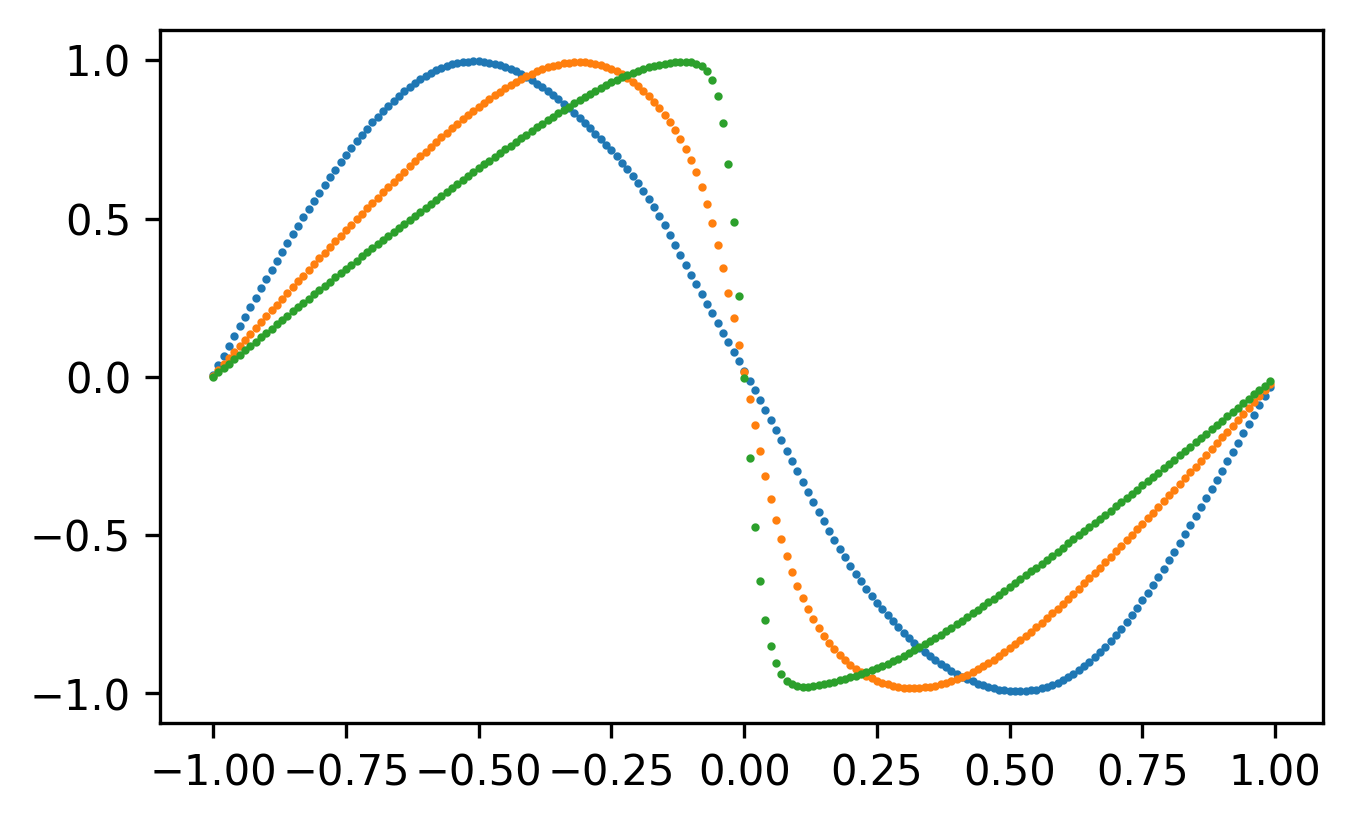

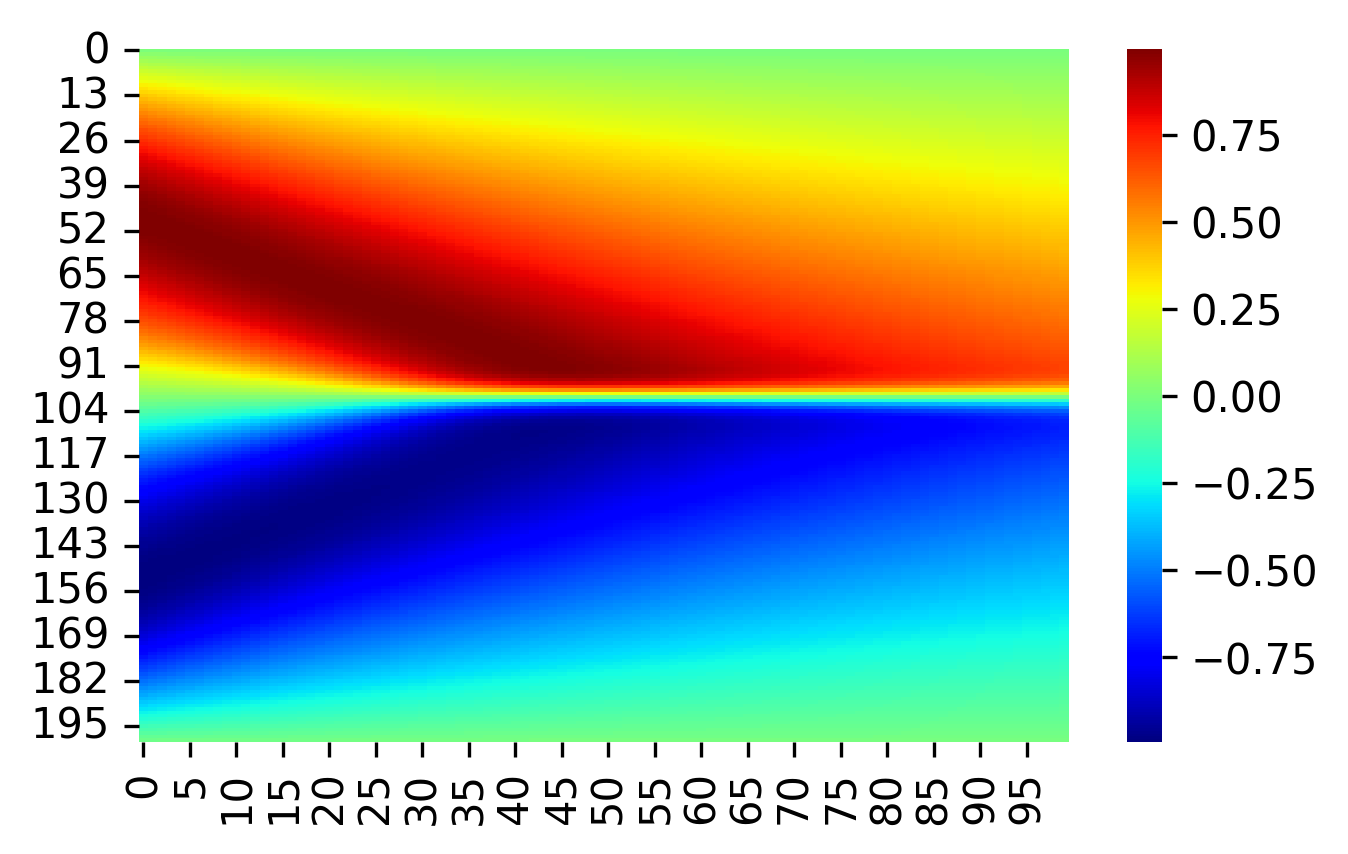

In [7]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# 选择GPU或CPU
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

# 从文件加载已经训练完成的模型
model_loaded = torch.load('model.pth', map_location=device)
model_loaded.eval()  # 设置模型为evaluation状态

# 生成时空网格
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(device)

# 计算该时空网格对应的预测值
with torch.no_grad():
    U_pred = model_loaded(X).reshape(len(x), len(t)).cpu().numpy()

# 绘制计算结果
plt.figure(figsize=(5, 3), dpi=300)
xnumpy = x.numpy()
plt.plot(xnumpy, U_pred[:, 0], 'o', markersize=1)
plt.plot(xnumpy, U_pred[:, 20], 'o', markersize=1)
plt.plot(xnumpy, U_pred[:, 40], 'o', markersize=1)
plt.figure(figsize=(5, 3), dpi=300)
sns.heatmap(U_pred, cmap='jet')
plt.show()


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np




In [13]:
type(U_pred)

numpy.ndarray

/env/lib/python3.11/site-packages/pysr/sr.py:865: FutureWarning: ncyclesperiteration has been renamed to ncycles_per_iteration in PySRRegressor. Please use that instead.
  warnings.warn(


IntProgress(value=0, description='Training:', max=1000)

/env/lib/python3.11/site-packages/pysr/sr.py:1238: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
/env/lib/python3.11/site-packages/pysr/sr.py:1309: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[-1.0000000e+00 -9.9000001e-01 -9.8000002e-01 -9.7000003e-01
 -9.5999998e-01 -9.4999999e-01 -9.4000000e-01 -9.3000001e-01
 -9.2000002e-01 -9.1000003e-01 -9.0000004e-01 -8.9000005e-01
 -8.8000000e-01 -8.7000000e-01 -8.6000001e-01 -8.5000002e-01
 -8.3999997e-01 -8.2999998e-01 -8.1999999e-01 -8.1000000e-01
 -7.9999995e-01 -7.8999996e-01 -7.7999997e-01 -7.6999998e-01
 -7.5999999e-01 -7.5000000e-01 -7.4000001e-01 -7.3000002e-01
 -7.1999997e-01 -7.0999998e-01 -6.9999999e-01 -6.9000000e-01
 -6.8000001e-01 -6.7000002e-01 -6.6000003e-01 -6.5000004e-01
 -6.3999999e-01 -6.3000000e-01 -6.2000000e-01 -6.1000001e-01
 -6.0000002e-01 -5.9000003e-01 -5.8000004e-01 -5.7000005e-01
 -5.6000000e-01 -5.5000001e-01 -5.4000002e-01 -5.3000003e-01
 -5.1999998e-01 -5.0999999e-01 -4.9999997e-01 -4.8999998e-01
 -4.7999999e-01 -4.6999997e-01 -4.5999998e-01 -4.4999999e-01
 -4.4000000e-01 -4.3000001e-01 -4.1999999e-01 -4.1000000e-01
 -4.0000001e-01 -3.8999999e-01 -3.8000000e-01 -3.7000000e-01
 -3.6000001e-01 -3.5000002e-01 -3.4000000e-01 -3.3000001e-01
 -3.2000002e-01 -3.1000000e-01 -3.0000001e-01 -2.9000002e-01
 -2.8000000e-01 -2.7000001e-01 -2.5999999e-01 -2.5000000e-01
 -2.3999999e-01 -2.3000000e-01 -2.2000000e-01 -2.1000001e-01
 -2.0000000e-01 -1.9000000e-01 -1.8000001e-01 -1.7000000e-01
 -1.6000000e-01 -1.5000001e-01 -1.4000000e-01 -1.3000001e-01
 -1.2000000e-01 -1.1000000e-01 -9.9999994e-02 -8.9999996e-02
 -7.9999998e-02 -7.0000000e-02 -5.9999999e-02 -4.9999997e-02
 -3.9999999e-02 -2.9999999e-02 -2.0000000e-02 -9.9999988e-03
  8.9406965e-10  1.0000001e-02  2.0000001e-02  3.0000001e-02
  3.9999999e-02  5.0000001e-02  5.9999999e-02  7.0000000e-02
  7.9999998e-02  8.9999996e-02  1.0000000e-01  1.1000000e-01
  1.2000000e-01  1.3000000e-01  1.4000000e-01  1.4999999e-01
  1.6000000e-01  1.7000000e-01  1.7999999e-01  1.9000000e-01
  2.0000000e-01  2.1000001e-01  2.2000000e-01  2.3000000e-01
  2.4000001e-01  2.5000000e-01  2.5999999e-01  2.7000001e-01
  2.8000000e-01  2.8999999e-01  3.0000001e-01  3.1000000e-01
  3.1999999e-01  3.3000001e-01  3.4000000e-01  3.4999999e-01
  3.6000001e-01  3.7000000e-01  3.8000003e-01  3.9000002e-01
  4.0000001e-01  4.1000003e-01  4.2000002e-01  4.3000001e-01
  4.4000000e-01  4.4999999e-01  4.6000001e-01  4.7000000e-01
  4.7999999e-01  4.9000001e-01  5.0000000e-01  5.0999999e-01
  5.1999998e-01  5.2999997e-01  5.3999996e-01  5.4999995e-01
  5.6000000e-01  5.6999999e-01  5.7999998e-01  5.8999997e-01
  6.0000002e-01  6.1000001e-01  6.2000000e-01  6.3000000e-01
  6.4000005e-01  6.5000004e-01  6.6000003e-01  6.7000002e-01
  6.8000001e-01  6.9000000e-01  6.9999999e-01  7.0999998e-01
  7.2000003e-01  7.3000002e-01  7.4000001e-01  7.5000000e-01
  7.5999999e-01  7.6999998e-01  7.7999997e-01  7.8999996e-01
  8.0000001e-01  8.1000000e-01  8.1999999e-01  8.2999998e-01
  8.3999997e-01  8.4999996e-01  8.5999995e-01  8.6999995e-01
  8.8000000e-01  8.8999999e-01  8.9999998e-01  9.0999997e-01
  9.2000002e-01  9.3000001e-01  9.4000000e-01  9.4999999e-01
  9.5999998e-01  9.7000003e-01  9.8000002e-01  9.9000001e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

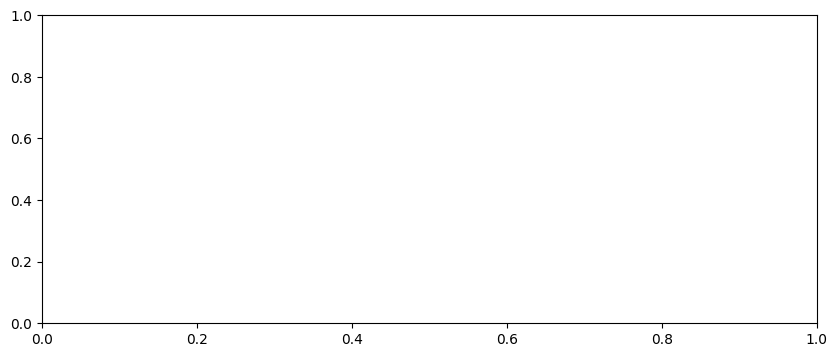

In [16]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
from pysr import PySRRegressor
import pandas as pd

# 准备数据
X = xnumpy # PySR 需要二维数组作为输入
y = U_pred.flatten()


# 初始化模型
model = PySRRegressor(
    procs=1,
    populations=3,
    niterations=1,  # 为了演示，我们每次只做一次迭代
    ncyclesperiteration=20,
    maxsize=300,
    parsimony=0.00001,
    unary_operators=["sin", "cos", "exp", "log"],
    warm_start = True,
)

# 准备绘图
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
progress_bar = widgets.IntProgress(value=0, min=0, max=1000, step=1, description='Training:')
display(progress_bar)

losses = []
scores = []

# 模拟的训练循环
for i in range(1000):
    model.fit(X, y)
    best_equation = model.get_best()
    loss = best_equation['loss']
    score = best_equation['score']
    losses.append(loss)
    scores.append(score)

    # 更新图表
    ax.clear()
    ax.plot(losses, label='Loss')
    ax.plot(scores, label='Score')
    ax.legend()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Value')
    ax.set_title('Training Progress')
    plt.show()

    # 更新进度条
    progress_bar.value += 1
    clear_output(wait=True)
    display(fig)
    display(progress_bar)



In [ ]:
# 获取最佳方程的 SymPy 表达式和 Python 函数
best_equation_sympy = model.get_best()["equation"]
best_equation_func = model.get_best()["lambda_format"]

print("最佳方程（SymPy）:", best_equation_sympy)
print("最佳方程（Python）:", best_equation_func)
# 为绘制方程准备数据


最佳方程（SymPy）: (3.1005423 / (0.07930065 + (exp(x0 + cos(-0.6861611 + x0)) / 0.02431236))) - 0.33950302
最佳方程（Python）: PySRFunction(X=>-0.33950302 + 3.1005423/(41.1313422473178*exp(x0 + cos(x0 - 0.6861611)) + 0.07930065))


In [ ]:
z_values = np.linspace(X.min(), X.max(), 500)
# 生成 z 值的二维数组版本，以满足 best_equation_func 的输入要求
z_values_2d = np.array([[z] for z in z_values])

# 计算 y 值
# 因为 best_equation_func 现在接收的是一个正确形状的二维数组，所以这里不会再出错
y_values = [best_equation_func(z) for z in z_values_2d]

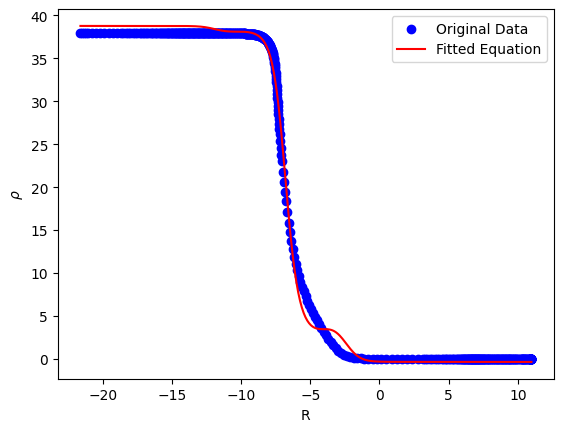

In [ ]:
plt.scatter(X, y, color='blue', label='Original Data')
# 绘制方程图像
plt.plot(z_values, y_values, color='red', label='Fitted Equation')
#plt.xscale('log')
#plt.yscale('log')
# 添加图例
plt.legend()

# 设置标签
plt.xlabel('R')
plt.ylabel(r'$\rho$')

# 显示图像
plt.show()